In [1]:
import numpy as np
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    x = np.array(x) / 3600 # convert second to hour
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze"):
    batch_num = 29
    latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7])
    latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08])
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 32 / 8 # 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "Quantize" : # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        # print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


Dyna-A-Freeze 1.9206833333333364
depth-5-width-16 1.9122222222222225
depth-4-width-16 1.5333333333333337
depth-3-width-16 1.1544444444444453
depth-2-width-16 0.7755555555555553
depth-1-width-16 0.3966666666666667
depth-0-width-16 0.16444444444444445
depth-11-width-8 8.161833333333341
depth-9-width-8 6.855555555555557
depth-7-width-8 5.339999999999998
depth-5-width-8 3.824444444444448
depth-3-width-8 2.3088888888888905
depth-1-width-8 0.7933333333333339
depth-12-width-64 6.6184444444444415
depth-11-width-64 6.069055555555559
depth-9-width-64 6.512777777777779
depth-7-width-64 5.339999999999998
depth-5-width-64 3.824444444444448
depth-3-width-64 2.3088888888888905
depth-1-width-64 0.7933333333333339
depth-9-width-96 5.998611111111112
depth-7-width-96 5.339999999999998
depth-5-width-96 3.824444444444448
depth-3-width-96 2.3088888888888905
depth-1-width-96 0.7933333333333339
depth-12-width-128 6.6184444444444415
depth-11-width-128 6.069055555555559
depth-9-width-128 4.9702777777777785
dept

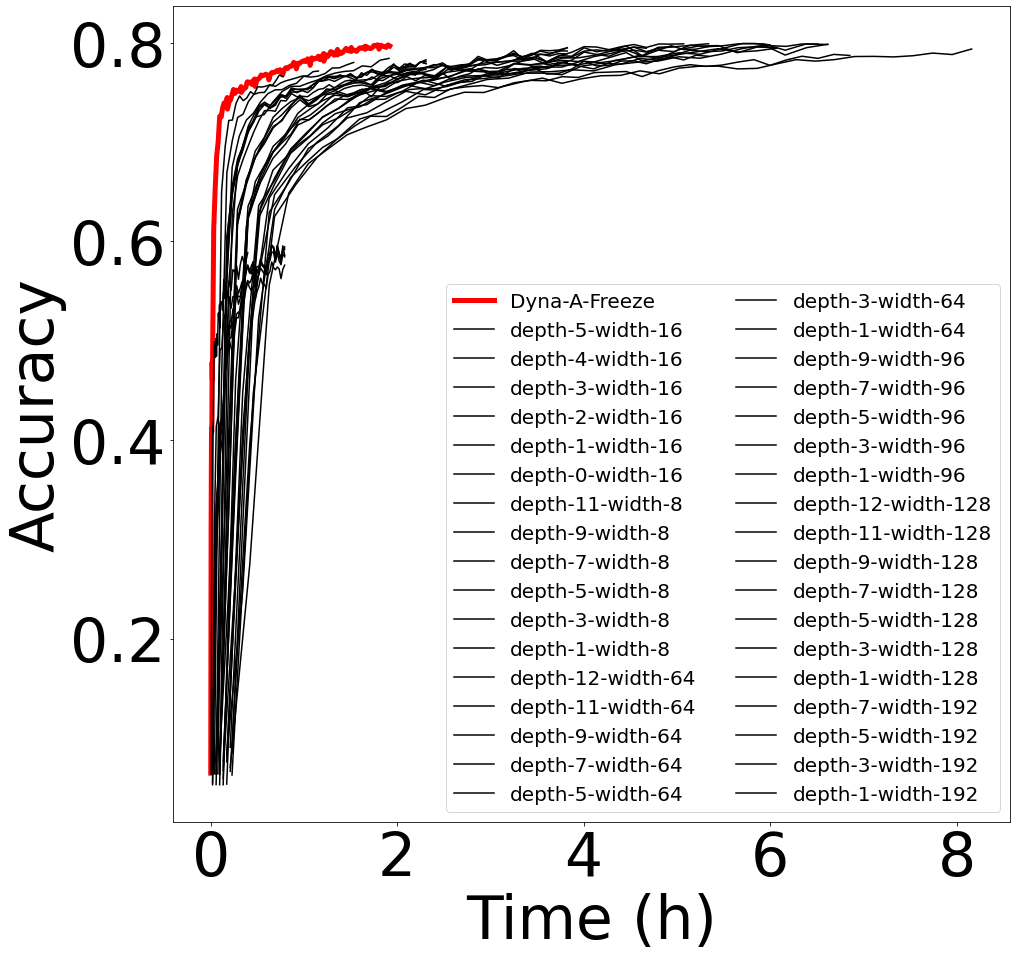

In [3]:
# 20news
# 20news
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)


# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)

ft = 60
plt.figure(figsize=(15,15))
# plt.title("Text Classification (20news)",fontsize=25)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Time (h)", fontsize=ft)
plt.ylabel("Accuracy", fontsize=ft)
# plt.grid(color = 'k', linestyle = '--', linewidth = 0.5, alpha=0.4)

from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc


time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Dyna-A-Freeze", color = "r", linewidth = 5)
print("Dyna-A-Freeze",time[-1])

data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/20news_bert.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
multiple = 20
for col in column_name:
    time = []
    d = int(col.split("-")[1])
    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
        tmp = idx
    time, data = cut(time, data, max_acc)
    plt.plot(np.array(time), data, label = col, color = 'k')
    print(col,time[-1])

plt.legend(fontsize=20,ncol = 2)
# plt.savefig('../figs/eval-ablation-trial-20news.pdf', bbox_inches="tight")